<h2> 자연어 처리 : 텍스트 분류 </h2>

In [1]:
import pandas as pd
import warnings 
warnings.filterwarnings(action='ignore')
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model, to_categorical
import warnings
import re
from matplotlib import pyplot as plt
from matplotlib import rcParams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pathlib import Path
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
import seaborn as sns
import warnings

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')

1 Physical GPUs, 1 Logical GPU


In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [4]:
ls "."

 C 드라이브의 볼륨: SSD
 볼륨 일련 번호: BCA4-98AF

 C:\Users\inhoinno\DACON\2020_DACON-Kaggle\소설저자AI 디렉터리

2020-11-20  오후 05:43    <DIR>          .
2020-11-20  오후 05:43    <DIR>          ..
2020-11-19  오전 12:29    <DIR>          .ipynb_checkpoints
2020-11-05  오후 05:31    <DIR>          ensemble
2020-10-09  오후 05:05         1,327,724 Logistic_regression.ipynb
2020-10-29  오후 06:12         3,959,848 NPL_base_5layer.h5
2020-11-12  오전 11:23            35,818 NPL_BaseLine.ipynb
2020-11-12  오전 11:23           958,128 NPL_BaseLine-CV.ipynb
2020-11-05  오전 12:07           934,892 NPL_BaseLine-LSTM.ipynb
2020-11-12  오전 11:23           942,567 NPL_BaseLine-ONE-HOT.ipynb
2020-11-20  오후 05:43           119,797 NPL_Base-Tfidf-CV.ipynb
2020-11-12  오전 11:23           927,110 NPL_LSTM_CV-Copy1.ipynb
2020-11-12  오전 11:28           941,359 NPL_LSTM-CV-Embedding.ipynb
2020-11-17  오후 01:59            45,713 NPL_LSTM-CV-Embedding-Glove.ipynb
2020-11-12  오후 10:35            39,893 NPL_RNN_Embedding.ipynb
2020-11-12  오전 1

In [5]:
#파일 불러오기
train = pd.read_csv('open/train.csv', encoding = 'utf-8')
test = pd.read_csv('open/test_x.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('open/sample_submission.csv', encoding = 'utf-8')

In [6]:
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [7]:
train.author.describe()

count    54879.0000
mean         1.9450
std          1.3916
min          0.0000
25%          1.0000
50%          2.0000
75%          3.0000
max          4.0000
Name: author, dtype: float64

<h2>전처리
    <h3> 1. 

In [8]:
#부호를 제거해주는 함수

def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9. ]', '', text)

train['text']=train['text'].apply(alpha_num)

In [9]:
#부호가 사라진 것을 확인할 수 있습니다.
#'.'문자는 그대로 있음
train

,index,text,author
0,0,He was almost choking. There was so much so mu...,3
1,1,Your sister asked for it I suppose,2
2,2,She was engaged one day as she walked in peru...,1
3,3,The captain was in the porch keeping himself c...,4
4,4,Have mercy gentlemen odin flung up his hands. ...,3
...,...,...,...
54874,54874,Is that you Mr. Smith odin whispered. I hardly...,2
54875,54875,I told my plan to the captain and between us w...,4
54876,54876,Your sincere wellwisher friend and sister LUC...,1
54877,54877,Then you wanted me to lend you money,3


In [10]:
def Mr_(text):
    return re.sub(r'Mr.', 'Mr ', text)

def Dr_(text):
    return re.sub(r'Dr.','Dr ',text)

train['text'] = train['text'].apply(Mr_)
train['text'] = train['text'].apply(Dr_)
train

,index,text,author
0,0,He was almost choking. There was so much so mu...,3
1,1,Your sister asked for it I suppose,2
2,2,She was engaged one day as she walked in peru...,1
3,3,The captain was in the porch keeping himself c...,4
4,4,Have mercy gentlemen odin flung up his hands. ...,3
...,...,...,...
54874,54874,Is that you Mr Smith odin whispered. I hardly...,2
54875,54875,I told my plan to the captain and between us w...,4
54876,54876,Your sincere wellwisher friend and sister LUC...,1
54877,54877,Then you wanted me to lend you money,3


1. 불용어 제거 remove_stopwords

In [11]:
# 불용어 제거해주는 함수
#def remove_stopwords(text):
#    final_text = []
#    for i in text.split():
#        if i.strip().lower() not in stopwords:
#            final_text.append(i.strip())
#    return " ".join(final_text)

# 불용어
#stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
#             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
#             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
#             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
#             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
#             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
#             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
#             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
#             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
#             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
#             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

<h2> 간단하게 EDA를 해볼까?

In [12]:
train.describe()

,index,author
count,54879.000,54879.0000
mean,27439.000,1.9450
std,15842.347,1.3916
min,0.000,0.0000
25%,13719.500,1.0000
50%,27439.000,2.0000
75%,41158.500,3.0000
max,54878.000,4.0000


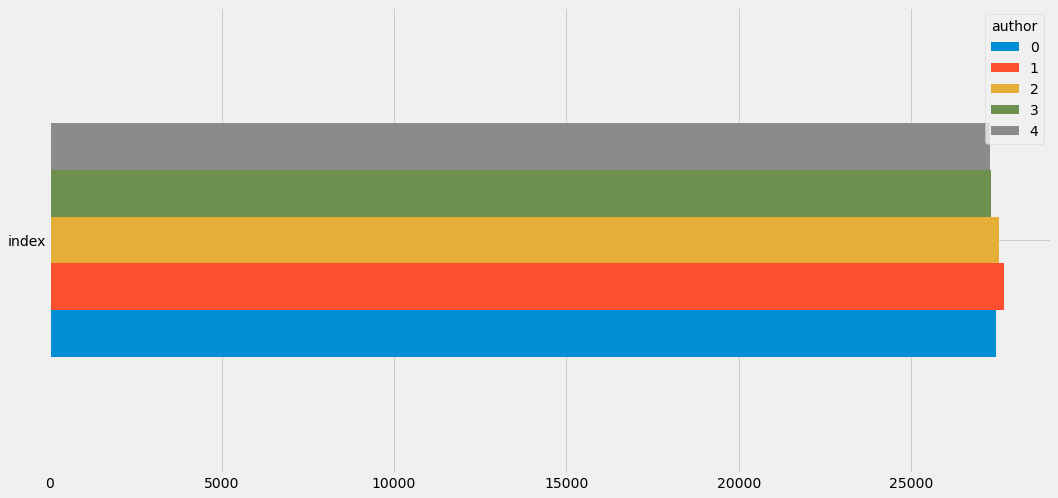

In [13]:
train.groupby('author').mean().T.plot(kind='barh')

In [14]:
train['length'] = train['text'].apply(len)
train

,index,text,author,length
0,0,He was almost choking. There was so much so mu...,3,235
1,1,Your sister asked for it I suppose,2,34
2,2,She was engaged one day as she walked in peru...,1,312
3,3,The captain was in the porch keeping himself c...,4,305
4,4,Have mercy gentlemen odin flung up his hands. ...,3,215
...,...,...,...,...
54874,54874,Is that you Mr Smith odin whispered. I hardly...,2,78
54875,54875,I told my plan to the captain and between us w...,4,93
54876,54876,Your sincere wellwisher friend and sister LUC...,1,53
54877,54877,Then you wanted me to lend you money,3,36


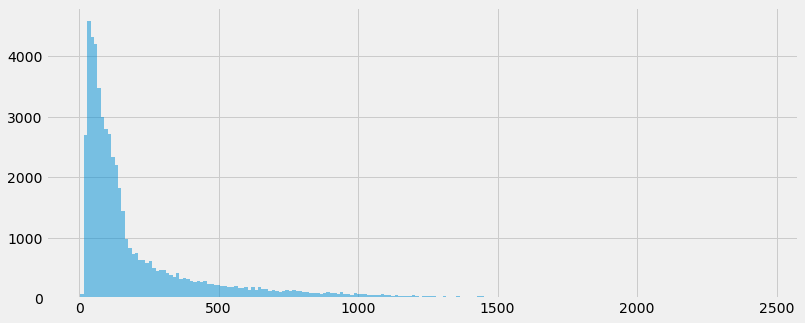

In [15]:
plt.figure(figsize = (12,5))
plt.hist(train['length'], bins=200, alpha= 0.5, label='word')
plt.show()

In [16]:
count = 0
index = [] 
i = 0;
for row in train['length'] : 
    if row > 500 : 
        index.append(i)
        count+=1
    i+=1
        
print(count)
print(len(index))
#전체 문장 중 단어 500개 가 넘어가는 문장은 6573 문장 (전체 데이터는 53000 정도이므로 매우 큼) 
#1000개 가 넘어가는 문장은 1599 문장
#1500개 132
#2000개 7
#따라서 부호를 제거 하기 전에 문장을 Split하는 과정이 필요함.

6832
6832


In [17]:
def mk_len(df):
    if 'length' not in df.column :
        df['length'] = df['text'].apply(len)
    return df
    
def mk_sentence_short(df):
    count = 0
    index = [] 
    i= 0
    df = mk_len(df)
    for length in train['length'] :
        if length > 500: 
            print(df['text'].iloc[i])
            #index.append(i)
            #count+=1
        i+=1
        
#mk_sentence_short(train)
train_over1000 = train[train['length']>500]
#train['author'].value_counts()
sample = train_over1000.head()

In [18]:
sam_text = sample['text'].iloc[0].split(".")
sam_auth = sample['author'].iloc[0]
sample.loc[54880] = [54880,sam_text[0],sam_auth, len(sam_text)]
#['index', 'text', 'author', 'len']
sample['index'].iloc[-1]

sample
# Sample을 통해서 index 27에서 1문장을 분리

,index,text,author,length
15,15,Still the ticking in the hall. Still the breat...,2,561
18,18,Before he could recover I was safe out of the ...,4,557
22,22,One word in conclusion. A strange cutter which...,2,807
27,27,From this day odin grew more comfortable. She ...,1,1103
32,32,Thus day followed day and as sure as morning c...,1,735
54880,54880,Still the ticking in the hall,2,8


In [19]:
# params : DataFrame 
# func :  get DF and make rows if it over 500 words

def split_text_mk_row(df):

    ran = len(df)
    last_index = df['index'].iloc[-1]
    
    for i in range(0,ran):
        if df['length'].iloc[i] > 500:
            #for every row in df
            sentence_list = df['text'].iloc[i].split(".")
            #get df['text'] to list 
            author = df['author'].iloc[i]
            #set author
            for t in sentence_list : 
                #add each line to df which is splited by "."
                if len(t) > 10 :
                    df.loc[last_index] = [last_index, t, author, len(t)]
                    last_index+=1
    return df

In [20]:
def df_length_reg(df, reg):
    if reg is None:
        reg = 500
    df_reg = df[df['length'] > reg]
    return df_reg
    

In [21]:
sample = train[train['length']>500]
sample

# leng

,index,text,author,length
15,15,Still the ticking in the hall. Still the breat...,2,561
18,18,Before he could recover I was safe out of the ...,4,557
22,22,One word in conclusion. A strange cutter which...,2,807
27,27,From this day odin grew more comfortable. She ...,1,1103
32,32,Thus day followed day and as sure as morning c...,1,735
...,...,...,...,...
54839,54839,It is unfortunately more than possible it is c...,2,584
54841,54841,Though harrowing to myself to mention the alie...,0,1013
54849,54849,As for Stepan odins son he had only seen him t...,3,1255
54855,54855,In the diningroom they were soon joined by od...,1,603


In [22]:
split_text_mk_row(sample)
sample = sample[sample['index']>54861]

KeyboardInterrupt: 

In [ ]:
sample.describe()

In [ ]:
train_split = pd.concat([train,sample])
train_split.describe()

In [ ]:
train_split = train_split.reset_index(drop=True)

In [ ]:
train_split = train_split.reset_index(drop=True)
train_split['index'] = train_split.index

In [ ]:
train_split

In [ ]:
df = train_split
df.to_csv('./train_processed_500.csv', index = False, encoding = 'utf-8')


In [ ]:
plt.figure(figsize = (12,5))
plt.hist(df['length'], bins=200, alpha= 0.5, label='word')
plt.show()

In [ ]:
df.describe()

In [23]:
df =  pd.read_csv('open/train_processed_500.csv', encoding = 'utf-8')

<h2> Tfidf Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1, 3), min_df=10)

In [ ]:
X = tfidf_vectorizer.fit_transform(train_split['text'])
X_tst =tfidf_vectorizer.transform(test['text'])

In [ ]:
X.todense()

<h2> Stratified K-Fold Cross Validation

In [24]:
n_fold = 5
n_class = 5
seed = 777


In [25]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

<h2> Keras 모델링

현재 코드는 Keras내부에서 바로 하는 Tokenizer 부분

In [26]:
#파라미터 설정
vocab_size = 2500
embedding_dim =64
max_length = 2500
padding_type='post'
oov_tok = "<OOV>"

In [27]:
X_train = df['text'].values
X_test = test['text'].values
y = df['author'].values
print(X_train.shape, X_test.shape, y.shape)

(183468,) (19617,) (183468,)


<h3> Embedding : Word2Vec, CBOW, Glove

In [ ]:
embedding_index = {}
f= open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in fi:
    values = line.split()
    word = values[0]
    
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_matrix = np.zeros(())

In [30]:
#tokenizer에 fit
tokenizer = Tokenizer(num_words = vocab_size)#, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [31]:
#데이터를 sequence로 변환해주고 padding 해줍니다.
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)

In [32]:
print(train_padded.shape,test_padded.shape)

(183468, 2500) (19617, 2500)


<h3> 가벼운 LSTM모델 생성

In [ ]:
#하이퍼 파라미터 설정
model_name = 'RNN classifier'
BATCH

In [ ]:
#가벼운 NLP모델 생성
model = tf.keras.Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(n_class, activation='softmax')
])

In [28]:
def get_base_model():

    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])    
    return model

In [ ]:
# compile model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

<h3> Stratified KFold NLP 모델 학습

In [ ]:
# fit model
num_epochs = 20
history = model.fit(train_padded, y_train, 
                    epochs=num_epochs, verbose=2, 
                    validation_split=0.2)

In [33]:
trn = train_padded
#y = df['author']
tst = test_padded
(trn.shape,y.shape,tst.shape)

((183468, 2500), (183468,), (19617, 2500))

In [34]:
tst

array([[ 20,  31,   6, ...,   0,   0,   0],
       [ 42, 335,   9, ...,   0,   0,   0],
       [ 19,   1, 214, ...,   0,   0,   0],
       ...,
       [ 12, 219, 482, ...,   0,   0,   0],
       [182, 108,  37, ...,   0,   0,   0],
       [  2,  31,   1, ...,   0,   0,   0]])

In [35]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))

for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    
    clf = get_base_model()
    
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                            patience=3, min_lr=1e-6, mode='min', verbose=1)

    clf.fit(trn[i_trn], 
            y[i_trn],
            validation_data=(trn[i_val],to_categorical(y[i_val])),
            epochs=10,
            callbacks=[es, rlr])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
Epoch 1/10
4584/4587 [============================>.] - ETA: 0s - loss: 1.5271 - accuracy: 0.3368

ValueError: in user code:

    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1208 run_step  **
        outputs = model.test_step(data)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1179 test_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:409 update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\utils\metrics_utils.py:90 decorated
        update_op = update_state_fn(*args, **kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:176 update_state_fn
        return ag_update_state(*args, **kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:612 update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:3301 sparse_categorical_accuracy
        y_true = array_ops.squeeze(y_true, [-1])
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py:507 new_func
        return func(*args, **kwargs)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:4259 squeeze
        return gen_array_ops.squeeze(input, axis, name)
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:10043 squeeze
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:3477 _create_op_internal
        ret = Operation(
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    C:\Users\inhoinno\anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 5 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](IteratorGetNext:1)' with input shapes: [?,5].


<h3> Submission

In [ ]:
# submission
sample_submission[['0','1','2','3','4']] = p_tst
sample_submission

In [ ]:
sample_submission.to_csv('open/sub/submission_processed500_BaseLine_CV.csv', index = False, encoding = 'utf-8')
